# 1. Dev: read
### 1.2 stlearn.read.10x_mtx

In [1]:
import stlearn as st
import pandas as pd

C:\Users\uqjxu8\AppData\Local\Continuum\anaconda3\envs\stlearn2\lib\site-packages\anndata\core\anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
C:\Users\uqjxu8\AppData\Local\Continuum\anaconda3\envs\stlearn2\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = st.read.file_10x_mtx("C:\\Users\\uqjxu8\\GIH\\Bioinformatics\\SPA\\Data\\visium\\Human_Breast_Cancer_Block_A_Section_1\\filtered_feature_bc_matrix")
data.var_names_make_unique()

# 2. Dev: add

### 2.1. stlearn.add.image

In [3]:
st.add.image(adata=data, imgpath="C:\\Users\\uqjxu8\\GIH\\Bioinformatics\\SPA\\Data\\visium\\Human_Breast_Cancer_Block_A_Section_1\\spatial\\tissue_lowres_image.png")

Trying to set attribute `.uns` of view, making a copy.


Added tissue image to the object!


### 2.2. stlearn.add.coordinates

In [4]:
st.add.positions(data,position_filepath = "C:\\Users\\uqjxu8\\GIH\\Bioinformatics\\SPA\\Data\\visium\\Human_Breast_Cancer_Block_A_Section_1\\spatial\\tissue_positions_list.csv",
                        scale_filepath = "C:\\Users\\uqjxu8\\GIH\\Bioinformatics\\SPA\\Data\\visium\\Human_Breast_Cancer_Block_A_Section_1\\spatial\\scalefactors_json.json",
                        quality = "low")

### 2.3 stlearn.add.cpdb

In [5]:
st.add.cpdb(adata=data, cpdb_filepath = "C:\\Users\\uqjxu8\\GIH\\Bioinformatics\\SPA\\Data\\visium\\Human_Breast_Cancer_Block_A_Section_1\\cpdb\\means.txt", sep="\t")


Added cpdb results to the object!


AnnData object with n_obs × n_vars = 3813 × 33538 
    obs: 'imagerow', 'imagecol'
    var: 'gene_ids', 'feature_types'
    uns: 'tissue_img', 'cpdb'

# 3 Dev: preprocessing

### 3.1. filter, normalize, scale & PCA

In [6]:
st.pp.filter_genes(data,min_cells=0.01*data.n_vars)
st.pp.normalize_total(data)
data.obsm['normalized'] = pd.DataFrame(data.X.toarray(), index=data.obs_names, columns=data.var_names)
st.pp.log1p(data)
st.pp.scale(data)
st.em.run_pca(data,n_comps=50)

filtered out 21848 genes that are detected in less than 335.38 cells
normalizing counts per cell
Normalization step is finished in adata.X
Log transformation step is finished in adata.X
Scale step is finished in adata.X
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']


### 3.3. add morphology information

In [7]:
st.pp.tiling(data,out_path="./temp_tiling",crop_size=40)
st.pp.extract_feature(data)
st.spatial.morphology.adjust(data,use_data='X_pca',radius=50,method="mean")
st.pp.neighbors(data,n_neighbors=25,use_rep='X_pca_morphology')

Tiling image: 100%|███████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]
Extract feature: 100%|████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]


The morphology feature is added to adata.obsm['X_morphology']!


Adjusting data: 100%|█████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]


The data adjusted by morphology is added to adata.obsm['X_pca_morphology']
Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 


# 5. Dev: tools


## B. Microenvironment analysis

### 5.1 Cell type heterogeneity

In [8]:
st.pp.neighbors(data,n_neighbors=25,use_rep='X_pca_morphology')

Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 


In [9]:
st.tl.clustering.louvain(data)

Applying Louvain clustering ...
Louvain clustering is done! The labels are stored in adata.obs['louvain']


In [10]:
counts = st.tl.cci.het.count(data, num=30)

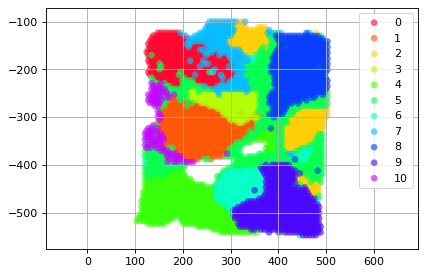

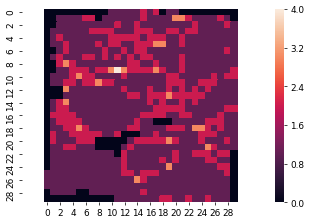

In [11]:
st.pl.het_plot(data, use_cluster='louvain', het=counts, dpi=80)

### 5.2 Cell-cell interaction based on spatial Ligand-Receptor expression
#### 5.2.1 Label Transfer

#### label transfer for all spots from a published breast cancer dataset

In [12]:
import pandas as pd
data.obs['predictions'] = pd.read_csv('predictions.csv', sep='\t')

Populating the interactive namespace from numpy and matplotlib


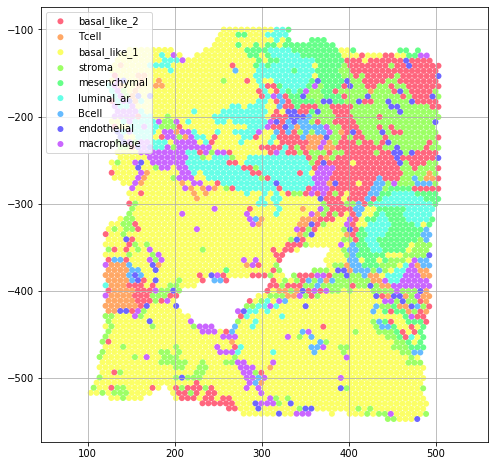

In [13]:
%pylab inline
figsize(8,8)
fig, ax = plt.subplots()
use_cluster='predictions'
num_clusters = len(set(data.obs[use_cluster])) + 1
ax.set_prop_cycle('color',plt.cm.gist_rainbow(np.linspace(0,1,num_clusters)))
for item in set(data.obs[use_cluster]):
    ax.scatter(np.array(data.obs[data.obs[use_cluster]==item]['imagecol']), 
                -np.array(data.obs[data.obs[use_cluster]==item]['imagerow']), 
               alpha=0.6, edgecolors='none')
ax.legend(set(data.obs[use_cluster]))
ax.grid(True)
plt.axis('equal');
plt.show()

#### 5.2.2 CCI clustering
#### cluster spatial spots based on the proportion of known ligand-receptor co-expression among the neighbouring spots

In [14]:
st.add.lr(data)
st.tl.cci.base.lr(adata=data, use_data='normalized', threshold=1, distance=10)

Added ligand receptor pairs to adata.uns['lr'].
Altogether 412 valid L-R pairs
L-R interactions with neighbours are counted and stored into adata['lr_neighbours']
Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 
Applying Louvain clustering ...
Louvain clustering is done! The labels are stored in adata.obs['louvain']
Spatial distribution of LR co-expression is written to adata.obsm['lr_neighbours']
Result of LR-clustering is kept in adata.obs['lr_neighbours_louvain']
The largest expressed LR neighbouring cluster is:  5


AnnData object with n_obs × n_vars = 3813 × 11690 
    obs: 'imagerow', 'imagecol', 'sum_counts', 'tile_path', 'louvain', 'predictions', 'lr_neighbours_louvain'
    var: 'gene_ids', 'feature_types', 'n_cells'
    uns: 'tissue_img', 'cpdb', 'log1p', 'pca', 'neighbors', 'louvain', 'lr', 'lr_neighbours_louvain_max'
    obsm: 'filtered_counts', 'normalized', 'X_pca', 'X_tile_feature', 'X_morphology', 'X_pca_morphology', 'lr_neighbours'
    varm: 'PCs'

#### plot the CCI clustering results

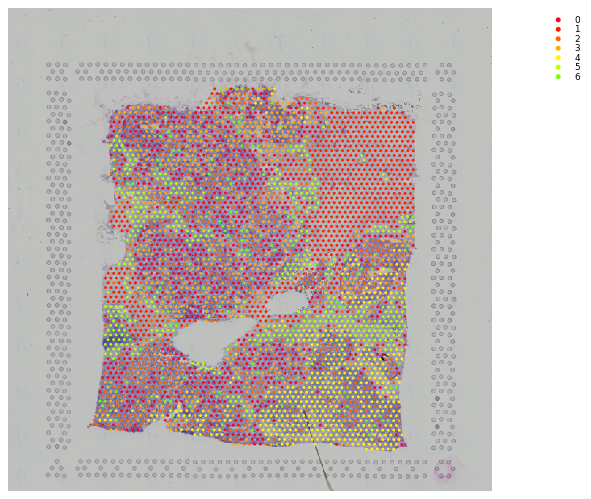

In [15]:
st.pl.cluster_plot(data,use_label="lr_neighbours_louvain", dpi=80)

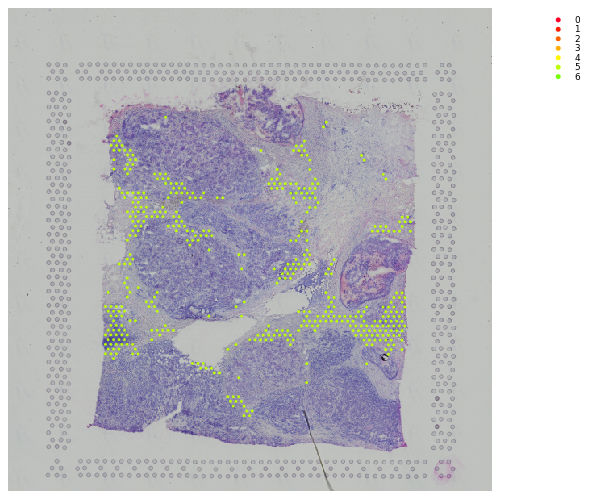

In [16]:
st.pl.cluster_plot(data,use_label="lr_neighbours_louvain",list_cluster=[data.uns['lr_neighbours_louvain_max']], dpi=80)

#### Compare the immune cells and the cci cluster

In [17]:
immune_cci = data.obs['lr_neighbours_louvain'].copy()
immune_cci = immune_cci.cat.set_categories(immune_cci.cat.categories.tolist()+['immune','non-immune'])
immune_cci[immune_cci!=data.uns['lr_neighbours_louvain_max']] = 'non-immune'
immune_cci[immune_cci==data.uns['lr_neighbours_louvain_max']] = 'immune'

immune_label = data.obs['predictions'].copy()
immune_label[immune_label.isin(['Bcell', 'Tcell', 'macrophage'])] = 'immune'
immune_label[immune_label!='immune'] = 'non-immune'

from sklearn.metrics.cluster import adjusted_rand_score
print(adjusted_rand_score(immune_cci, immune_label))

0.4043270890677005


In [18]:
import scanpy as sc
from anndata import AnnData
rank_test = AnnData(data.obsm['lr_neighbours'])
rank_test.obs['lr_neighbours_louvain'] = data.obs['lr_neighbours_louvain']
sc.tl.rank_genes_groups(rank_test, 'lr_neighbours_louvain', method='t-test')
pd.DataFrame(rank_test.uns['rank_genes_groups']['names']).iloc[0:15,]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


0             1              2              3  \
0      LGALS9_DAG1    CCL5_ACKR1      CD74_COPA     SORT1_COPA   
1      DAG1_LGALS9    ACKR1_CCL5      COPA_CD74     COPA_SORT1   
2    LGALS9_SLC1A5    CCL2_ACKR1       CD74_APP      GRN_SORT1   
3    SLC1A5_LGALS9    ACKR1_CCL2       APP_CD74      SORT1_GRN   
4      LGALS9_CD47     ESAM_ESAM       CD74_MIF      CD74_COPA   
5      CD47_LGALS9     ESAM_ESAM       MIF_CD74      COPA_CD74   
6      CD44_LGALS9      PGF_NRP2   TNFRSF1A_GRN       APP_CD74   
7      LGALS9_CD44      NRP2_PGF   GRN_TNFRSF1A       CD74_APP   
8   LGALS9_COLEC12  PDGFRA_PDGFA      DSG2_DSC2       CD74_MIF   
9   COLEC12_LGALS9  PDGFA_PDGFRA      DSC2_DSG2       MIF_CD74   
10     LGALS9_LRP1    ACKR1_CCL8  TNFSF10_RIPK1  SEMA4C_PLXNB2   
11     LRP1_LGALS9    CCL8_ACKR1  RIPK1_TNFSF10  PLXNB2_SEMA4C   
12       COPA_CD74   IL15_IL15RA     FLT1_VEGFA     MST1R_MST1   
13       CD74_COPA   IL15RA_IL15     VEGFA_FLT1     MST1_MST1R   
14        CD74_APP      PGF_FLT1    NOTCH3_JAG2  TNFSF10_RIPK1   

                  4             5             6  
0   CEACAM6_CEACAM6   LRP1_LGALS9   LAMP1_FAM3C  
1   CEACAM6_CEACAM6   LGALS9_LRP1   FAM3C_LAMP1  
2         COPA_CD74      LRP1_MDK   FAM3C_HLA-C  
3         CD74_COPA      MDK_LRP1   HLA-C_FAM3C  
4         SPP1_CD44  CXCR4_CXCL12      MIF_CD74  
5         CD44_SPP1  CXCL12_CXCR4      CD74_MIF  
6          CD74_MIF  TNFRSF1B_GRN     CD74_COPA  
7          MIF_CD74  GRN_TNFRSF1B     COPA_CD74  
8      TNFRSF1A_GRN   LGALS9_CD44  FAM3C_CLEC2D  
9      GRN_TNFRSF1A   CD44_LGALS9  CLEC2D_FAM3C  
10  CEACAM1_CEACAM6      AXL_GAS6   FAM3C_CXADR  
11  CEACAM6_CEACAM1      GAS6_AXL   CXADR_FAM3C  
12        DSC2_DSG2   LGALS9_MRC2      APP_CD74  
13        DSG2_DSC2   MRC2_LGALS9      CD74_APP  
14    RIPK1_TNFSF10      LTBR_LTB   FAM3C_FFAR2

C:\Users\uqjxu8\GIH\Github\stLearn\stlearn\plotting\cci_plot.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  violin['cci_cluster'] = adata.obs['lr_neighbours_' + use_cluster]


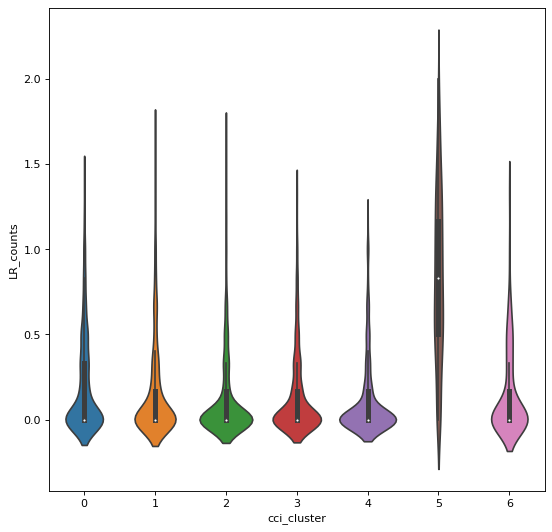

In [19]:
st.pl.violin_plot(data, lr='CXCR4_CXCL12', use_cluster='louvain', dpi=80)

#### barplot to show the cell type compositions in each cluster

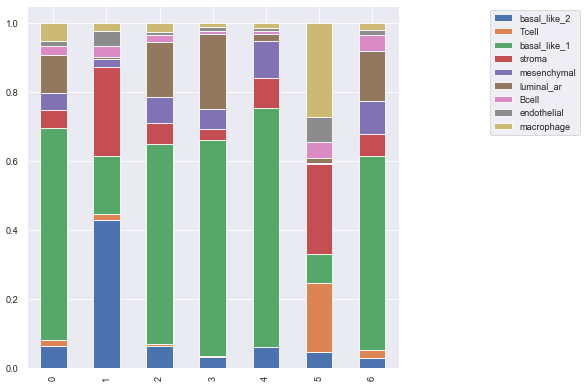

In [20]:
st.pl.stacked_bar_plot(data, use_annotation='predictions', dpi=60)

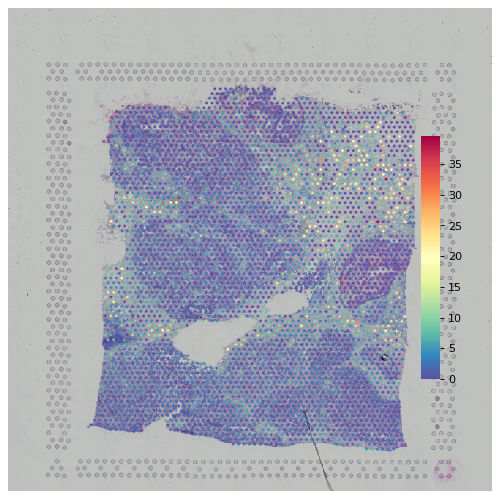

In [33]:
st.pl.gene_plot(data, genes=['LGALS9','LRP1'], method="CumSum", dpi=80)

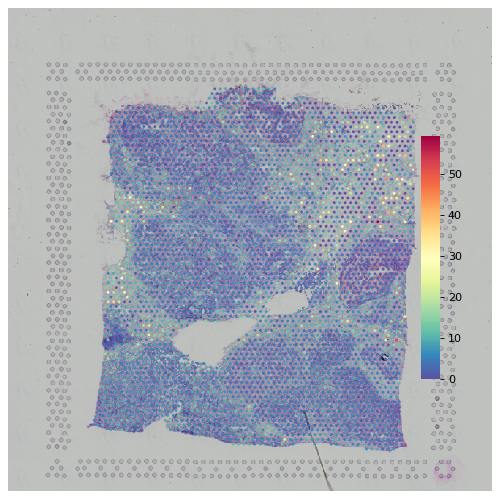

In [41]:
st.pl.gene_plot(data, genes=['MDK','LRP1'], method="CumSum", dpi=80)

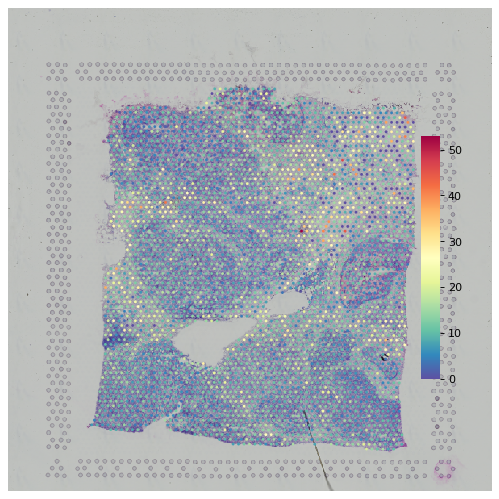

In [35]:
st.pl.gene_plot(data, genes=['TNFRSF1B','GRN'], method="CumSum", dpi=80)

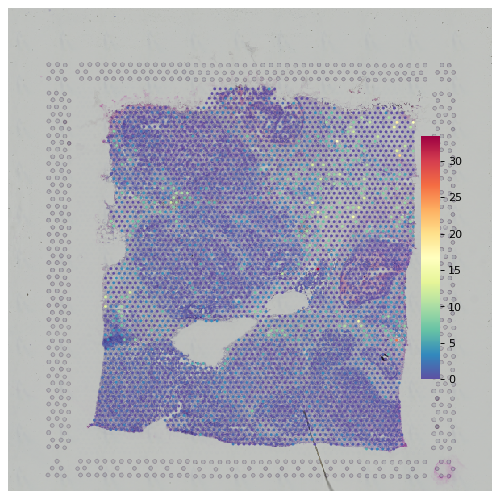

In [37]:
st.pl.gene_plot(data, genes=['CSF1R','CSF1'], method="CumSum", dpi=80)

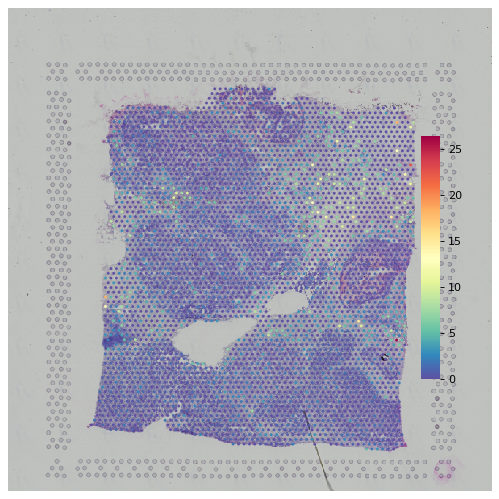

In [38]:
st.pl.gene_plot(data, genes=['CSF1R','IL34'], method="CumSum", dpi=80)

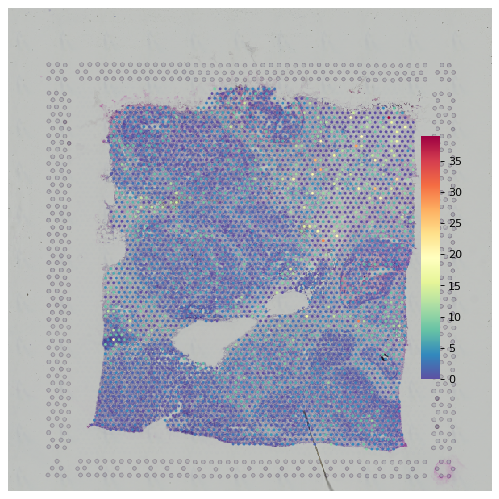

In [39]:
st.pl.gene_plot(data, genes=['CD44','LGALS9'], method="CumSum", dpi=80)

### 5.3 SpatialDE

In [45]:
st.tl.SpatialDE(data, top_genes=10)

C:\Users\uqjxu8\GIH\Github\stLearn\stlearn\tools\microenv\SpatialDE\base.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  s2_logdelta = 1. / (derivative(LL_obj, np.log(max_delta), n=2) ** 2)



SpatialDE results stored in adata.uns['SpatialDE_results'] and adata.uns['SpatialDE_top_genes']


#### Plot top spatially differential expressing genes

Populating the interactive namespace from numpy and matplotlib


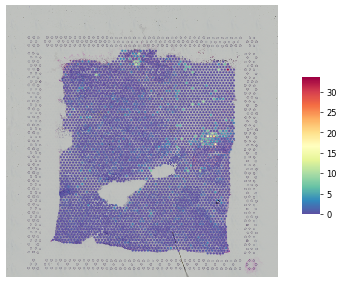

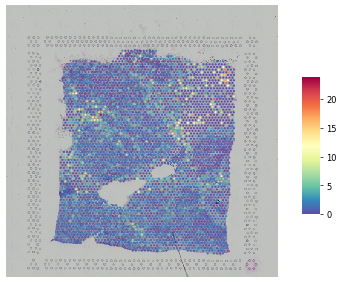

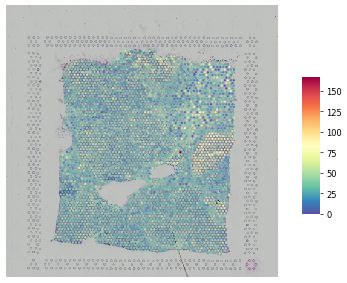

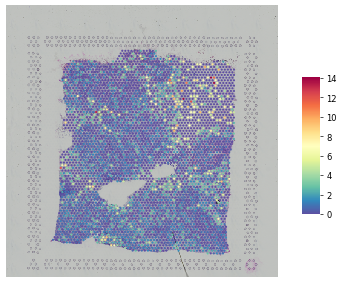

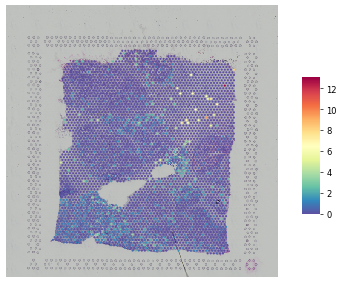

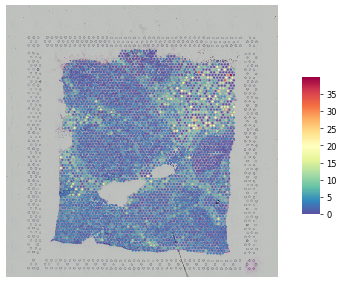

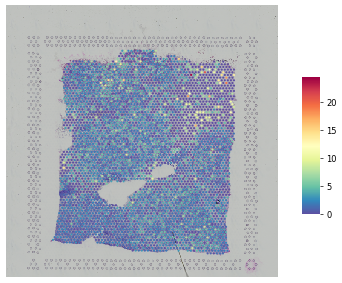

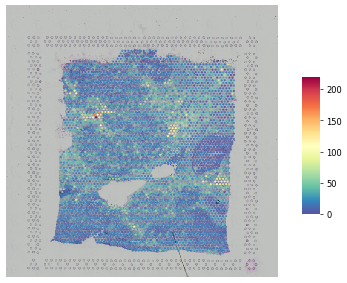

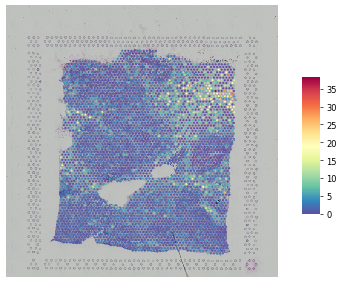

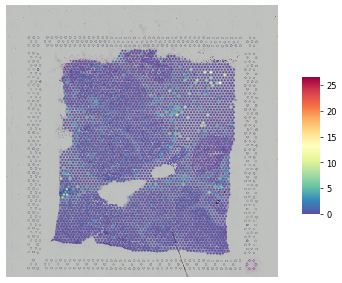

In [50]:
%pylab inline
figsize(10, 6)
for i, g in enumerate(data.uns['SpatialDE_top_genes']):
    st.pl.gene_plot(data, genes=data.uns['SpatialDE_top_genes'][i], title=data.uns['SpatialDE_top_genes'][i], dpi=60)

#### Automatic expression histology (stlearn.tl.SpatialDE.aeh)

#### assuming 5 different patterns and iterate till ELBO converges
#### (Careful! This step could take very long time)

In [47]:
st.tl.microenv.spatial_patterns(data, data.uns['SpatialDE_results'], C=3)

C:\Users\uqjxu8\GIH\Github\stLearn\stlearn\tools\microenv\SpatialDE\base.py:45: RuntimeWarning: divide by zero encountered in true_divide
  return np.exp(-R2 / (2 * l ** 2))


Warning! ELBO dit not converge after 100 iters!


#### Plot all spatial expression patterns with genes in each pattern

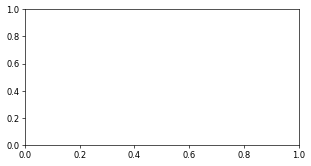

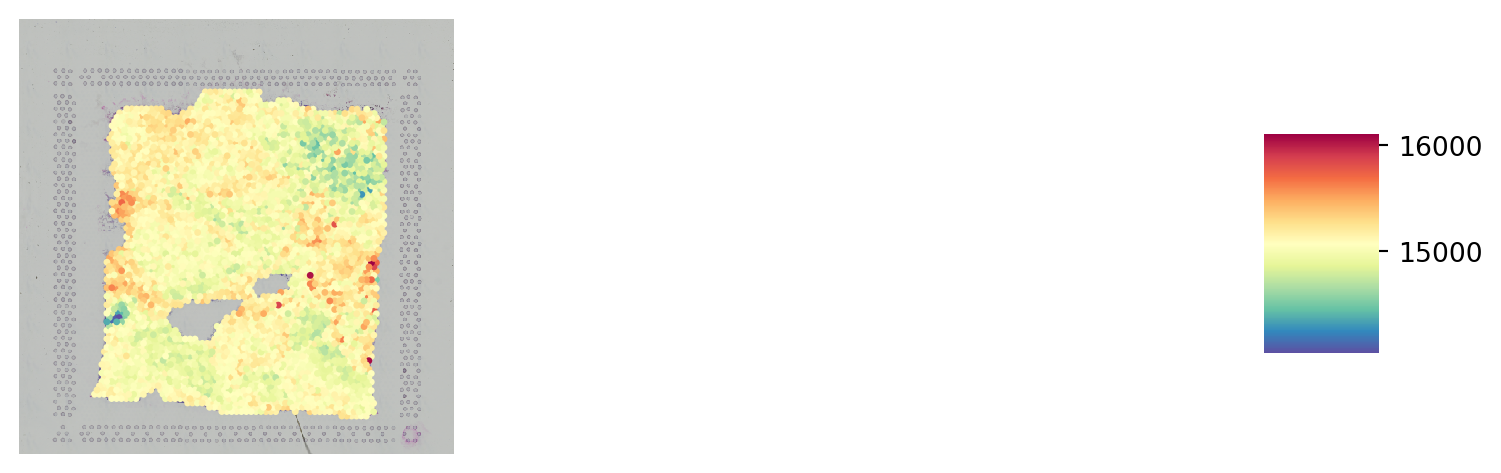

In [63]:
figsize(20, 3)
for i in range(3):
    plt.subplot(1, 3, i + 1)
    st.pl.gene_plot(data, genes=data.uns['pattern_'+str(i)], method="CumSum")

In [62]:
for i in range(3):
    print('Pattern {}'.format(i))
    print(data.uns['pattern_' + str(i)])
    print()

Pattern 0
[]

Pattern 1
['MT-ATP6', 'MT-CYB', 'RPL41', 'MT-CO3', 'MT-ND4', 'MGP', 'MT-ND3', 'S100A6', 'RPS18', 'MALAT1', 'RPL32', 'SPAG4', 'MT-CO2', 'MT-ND2', 'BNIP3', 'RPL30', 'MT-CO1', 'IGLC3', 'RPS27', 'TENT5C', 'IGHG3', 'ZNF350-AS1', 'RPL36', 'DERL3', 'CCNO', 'IGHGP', 'GAPDH', 'CITED2', 'RPL8', 'ALDOA', 'APOD', 'SPAG6', 'IGHG2', 'CD79A', 'HMGB3', 'RMND1', 'KRT37', 'AL445524.1', 'RPS14', 'VSIG10L2', 'Z82214.2', 'IGKC', 'RPL37A', 'CYP4X1', 'SPTSSB', 'INHA', 'MYEOV', 'SRD5A3', 'IGLC2', 'PDK1', 'RPL29', 'JSRP1', 'MT-ND1', 'SERPINA11', 'NDRG1', 'KCNJ8', 'CHCHD7', 'NME2', 'LURAP1L', 'RPL18A', 'HILPDA', 'MT-ATP8', 'BRINP3', 'C16orf45', 'S100A2', 'AK4', 'IGF1R', 'IGHG1', 'LRG1', 'ARPP21', 'GPC4', 'HIST2H4A', 'S100A8', 'S100A9', 'PFKP', 'C17orf58', 'PIM2', 'ANG', 'ERP27', 'HIST1H2BG', 'WIPI1', 'RPL23A', 'SNHG8', 'PLOD2', 'PITX1', 'PGC', 'CEP135', 'KRT14', 'RPL7A', 'MIR210HG', 'CEBPD', 'CXCL17', 'RNASE4', 'NEURL3', 'BASP1', 'EPPK1', 'MT-ND5', 'AC008663.1', 'PLAC4', 'JCHAIN', 'AARD', 'ELL2', 


Pattern 2
[]

